# Land Cover Classification with EuroSAT

## 2020년 08월 31일 안상호

In [51]:
!pwd

/home/jovyan/Land-Cls/02_EuroSAT


In [52]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='2'

In [53]:
from pathlib import Path

# Sangho Workspace|
root_dir = Path("/home/jovyan/")
base_dir = root_dir  / 'Land-Cls'

data_path = base_dir / "data" 

In [54]:
from fastai.vision import *

In [55]:
import torch 

print(torch.cuda.is_available())
torch._C._cuda_getDriverVersion()
# torch.cuda.get_device_name(0)

True


10010

In [56]:
!nvidia-smi

Wed Sep  2 08:37:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.116.00   Driver Version: 418.116.00   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0E:00.0 Off |                    0 |
| N/A   39C    P0    51W / 300W |  14856MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   38C    P0    51W / 300W |  10127MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [57]:
import sys
import os

# Google Colab Version
# sys.path.append(str(base_dir))


# Local Version
PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser("__file__"))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from utils import preprocess, model #earth

# 1. Training Test

## 1.1. Create Databunch

In [6]:
from fastai.vision import *

path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [7]:
src = (ImageList.from_folder(data_path / "eurosat")
       .split_by_rand_pct(0.2)
       .label_from_folder())

In [8]:
data = (src.transform(get_transforms(), size=128)
        .databunch().normalize(imagenet_stats))

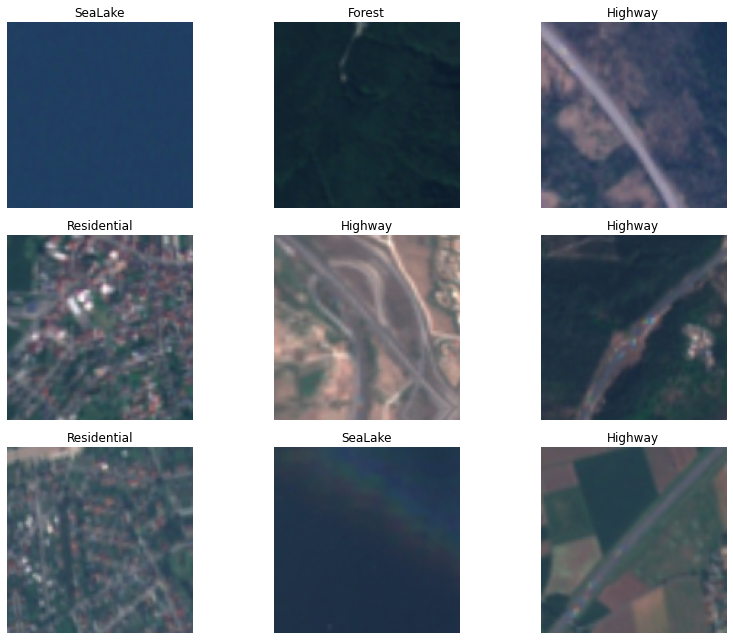

In [27]:
data.show_batch(rows=3, figsize=(12,9))

## 1.2. Create and Train Learner

In [10]:
arch = models.resnet50

learn = cnn_learner(data, arch, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 8.32E-03


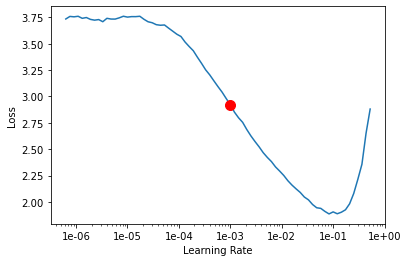

In [11]:
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(15, 5E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.312848,0.158163,0.952222,00:26
1,0.211372,0.150398,0.955000,00:27
2,0.226829,0.176104,0.941111,00:26
3,0.216677,0.412689,0.882593,00:26
4,0.189861,0.104933,0.966296,00:26
5,0.172166,0.112323,0.962593,00:25
6,0.127750,0.115018,0.960741,00:27
7,0.108404,0.078391,0.974630,00:27
8,0.104214,0.070293,0.977593,00:27
9,0.089696,0.059335,0.979815,00:27


# 2. Experimenting with Class

In [31]:
from sklearn.metrics import f1_score

@np_func
def f1_macro(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='macro')

@np_func
def f1_weighted(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

## 2.1. ResNet50

### Pretraining with ImageNet

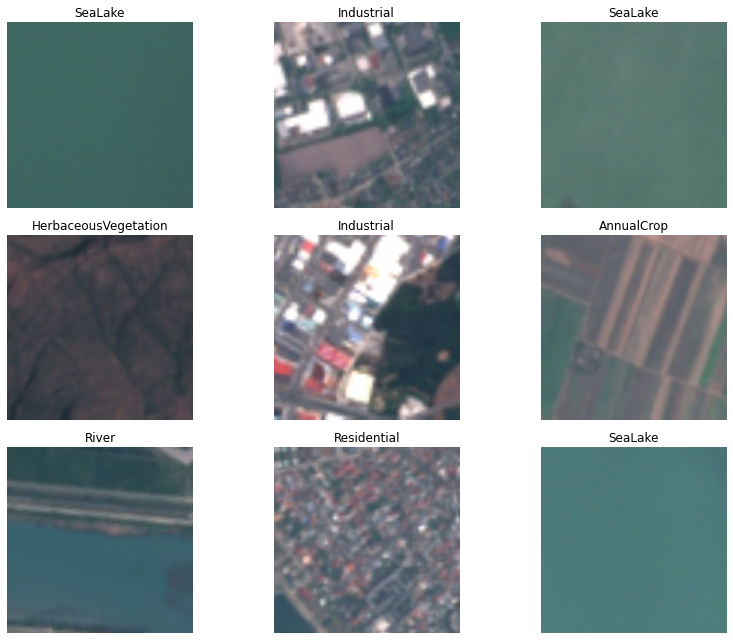

In [32]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet50, parameters, task="classification")
# vis.find_alpha()


In [50]:
vis.fit_model_cyc(15, 5e-03)

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,0.264607,0.151243,0.947778,0.939776,0.947658,01:13
1,0.169933,0.155345,0.947593,0.940646,0.947221,01:13
2,0.178391,0.117393,0.962593,0.956447,0.962218,01:13
3,0.182987,0.149215,0.955185,0.947488,0.954291,01:12
4,0.168075,0.460471,0.854259,0.846304,0.850314,01:12
5,0.166385,0.285142,0.903704,0.895892,0.904475,01:13
6,0.144086,0.212441,0.932963,0.920350,0.931117,01:13
7,0.124786,0.151400,0.949815,0.941623,0.950067,01:13
8,0.133663,0.119290,0.961667,0.956135,0.961378,01:13
9,0.110405,0.106577,0.965185,0.959813,0.965748,01:13


In [51]:
vis.learn.save(base_dir / "learn" / "euro-res50-1")

In [12]:
vis.learn.load(base_dir / "learn" / "euro-res50-1")

Learner(data=ImageDataBunch;

Train: LabelList (21600 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop
Path: /home/jovyan/Land-Cls/data/eurosat;

Valid: LabelList (5400 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
HerbaceousVegetation,Industrial,Highway,Industrial,HerbaceousVegetation
Path: /home/jovyan/Land-Cls/data/eurosat;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-06


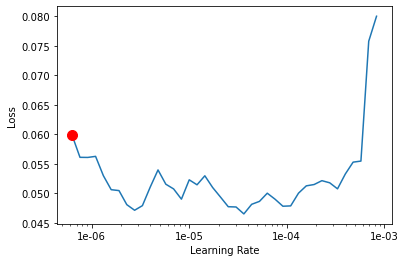

In [13]:
vis.learn.unfreeze()

vis.find_alpha()

In [14]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))
vis.learn.save(base_dir / "learn" / "euro-res50-2")

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,0.045181,0.026606,0.992778,0.992382,0.992762,01:35
1,0.045523,0.026989,0.991667,0.990782,0.991661,01:34
2,0.037896,0.027474,0.990926,0.990716,0.990903,01:35
3,0.045295,0.028015,0.991667,0.990846,0.991643,01:35
4,0.044025,0.028223,0.991852,0.991057,0.991833,01:35
5,0.042809,0.027229,0.991296,0.990416,0.991287,01:34
6,0.038096,0.026635,0.991481,0.990889,0.991463,01:35
7,0.035800,0.026519,0.991481,0.990706,0.991474,01:35
8,0.035993,0.026236,0.992407,0.991718,0.992405,01:35
9,0.030899,0.026578,0.992037,0.991398,0.992029,01:34


### Pretraining from Scratch

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 8.32E-03


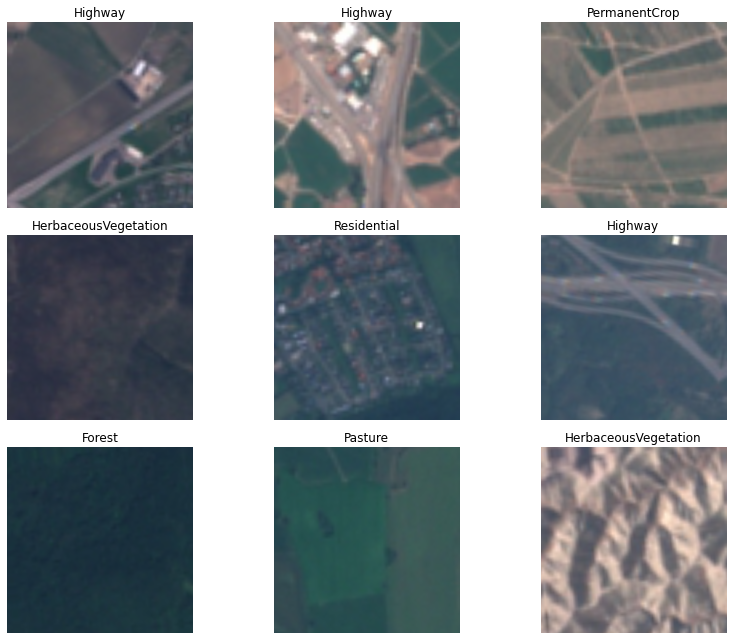

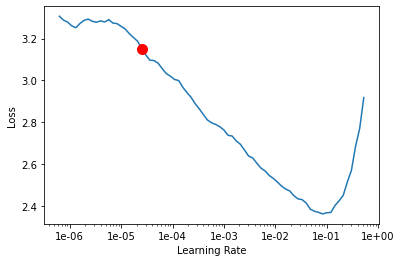

In [15]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet50, parameters, task="classification")
vis.find_alpha()


In [16]:
vis.fit_model_cyc(15, 5e-03)

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,1.084497,0.859723,0.706111,0.680190,0.705018,01:35
1,0.986891,0.794242,0.720370,0.690316,0.718766,01:35
2,0.880953,1.618261,0.543889,0.487186,0.510611,01:35
3,0.818283,2.014446,0.510000,0.436931,0.452427,01:35
4,0.608214,1.933891,0.497963,0.479357,0.490364,01:35
5,0.517498,0.501600,0.823148,0.796377,0.818611,01:35
6,0.458017,2.415684,0.491481,0.457119,0.471039,01:35
7,0.422290,1.122766,0.732407,0.698918,0.706820,01:35
8,0.366930,0.359187,0.873889,0.854507,0.871826,01:35
9,0.340573,0.303103,0.899815,0.887486,0.899241,01:35


In [17]:
vis.learn.save(base_dir / "learn" / "euro-res50-r-1")

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-07


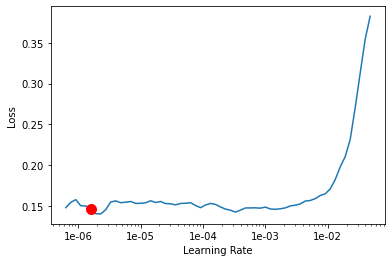

In [18]:
vis.learn.unfreeze()

vis.find_alpha()

In [19]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))
vis.learn.save(base_dir / "learn" / "euro-res50-r-2")

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,0.138978,0.113086,0.962037,0.956794,0.962055,01:34
1,0.157852,0.113737,0.962407,0.958428,0.962401,01:34
2,0.148588,0.110196,0.963704,0.958864,0.963764,01:35
3,0.139260,0.108604,0.965741,0.961665,0.965599,01:35
4,0.145901,0.107137,0.964259,0.960017,0.964112,01:35
5,0.145462,0.107826,0.965370,0.961545,0.965223,01:35
6,0.158533,0.109611,0.963519,0.958475,0.963586,01:35
7,0.155272,0.108389,0.965741,0.961659,0.965532,01:35
8,0.151359,0.105786,0.964815,0.959675,0.964792,01:35
9,0.149760,0.108010,0.964074,0.959910,0.963953,01:35


## 2.2. ResNet101

### Pretraining with ImageNet

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.20E-02


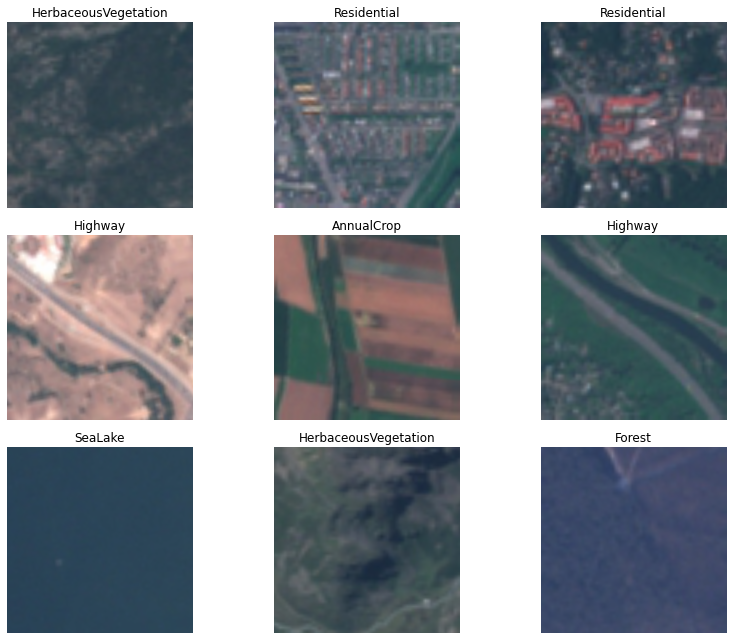

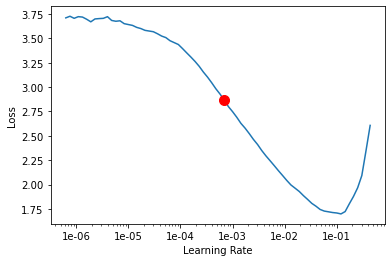

In [44]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet101, parameters, task="classification")
vis.find_alpha()


In [45]:
vis.fit_model_cyc(15, 5e-03)

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,0.215584,0.153274,0.946111,0.937964,0.945608,01:56
1,0.171434,0.121975,0.960000,0.956223,0.959714,01:56
2,0.182220,0.267032,0.905000,0.897435,0.905718,01:57
3,0.205724,0.332725,0.884074,0.874038,0.886025,01:57
4,0.196795,0.342740,0.890926,0.875218,0.887155,01:56
5,0.161606,0.142161,0.953148,0.946860,0.953272,01:56
6,0.167455,0.424894,0.861111,0.844758,0.849466,01:56
7,0.143794,0.247222,0.902778,0.896014,0.900660,01:56
8,0.116157,0.115110,0.964815,0.961347,0.964839,01:57
9,0.119401,0.173499,0.933704,0.925103,0.931503,01:56


- 성능 향상을 위한 fine-tunning

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 4.79E-07


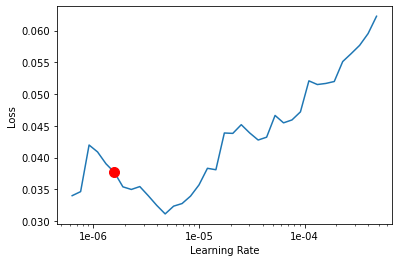

In [46]:
vis.learn.unfreeze()

vis.find_alpha()

In [47]:
vis.fit_model_cyc(15, 1e-05)

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,0.042968,0.031617,0.987593,0.986400,0.987547,02:34
1,0.036896,0.033509,0.987222,0.986496,0.987205,02:35
2,0.040991,0.031735,0.989259,0.987709,0.989277,02:34
3,0.038279,0.033063,0.988889,0.987353,0.988876,02:34
4,0.033016,0.036955,0.987407,0.985128,0.987345,02:34
5,0.034022,0.033434,0.988333,0.986969,0.988309,02:37
6,0.037643,0.035323,0.986481,0.984515,0.986454,02:35
7,0.029189,0.030131,0.990000,0.988411,0.989969,02:35
8,0.033044,0.030822,0.989259,0.988436,0.989167,02:35
9,0.027394,0.029713,0.990370,0.989311,0.990370,02:35


In [48]:
vis.learn.save(base_dir / "learn" / "euro-res101")

### Pretraining from Scratch

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 4.79E-03


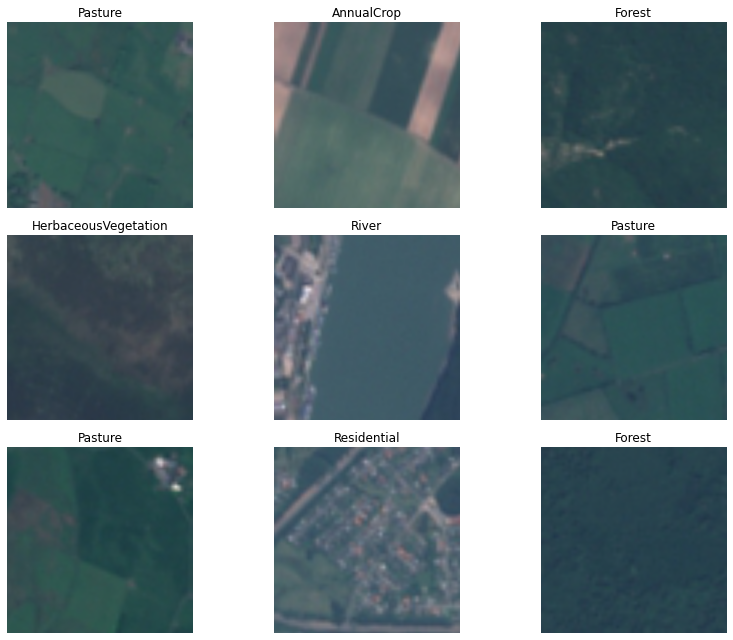

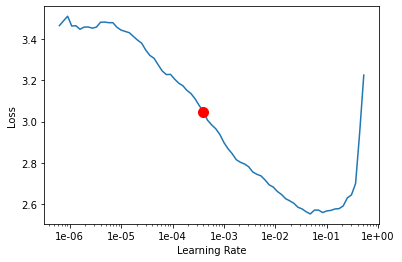

In [33]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet101, parameters, task="classification")
vis.find_alpha()


In [34]:
vis.fit_model_cyc(15, 5e-03)

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,1.218598,0.920204,0.680185,0.632973,0.657202,02:36
1,1.010393,1.143338,0.608704,0.557204,0.580030,02:35
2,1.069339,1.075903,0.611667,0.571297,0.597462,02:36
3,0.930218,1.717524,0.477593,0.402922,0.430582,02:35
4,0.708102,1.921850,0.505185,0.456476,0.489726,02:35
5,0.576063,1.329067,0.611481,0.558151,0.587480,02:35
6,0.510946,0.526747,0.823519,0.804136,0.814964,02:35
7,0.442002,0.600193,0.785000,0.760153,0.779163,02:34
8,0.409997,0.497875,0.844815,0.827778,0.842636,02:35
9,0.344291,0.678171,0.773148,0.745748,0.769987,02:34


epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 3.98E-05


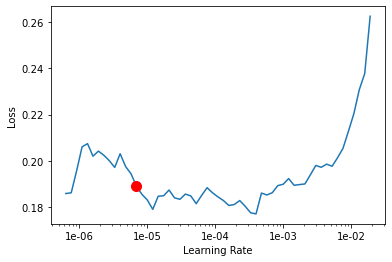

In [35]:
vis.find_alpha()

In [36]:
vis.learn.fit_one_cycle(10, max_lr=slice(5e-04))

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,0.174741,0.284284,0.952037,0.944637,0.951776,02:34
1,0.174334,0.529429,0.950000,0.943213,0.949766,02:34
2,0.166520,0.266447,0.951296,0.944414,0.951295,02:34
3,0.170385,0.557354,0.953704,0.945724,0.953460,02:34
4,0.166874,0.587704,0.950370,0.943601,0.950191,02:34
5,0.164796,0.831211,0.952778,0.945616,0.952640,02:34
6,0.152579,0.180876,0.957778,0.951534,0.957537,02:34
7,0.144211,0.959200,0.949630,0.941275,0.949271,02:34
8,0.146130,0.756613,0.947778,0.939911,0.947480,02:35
9,0.149241,0.408380,0.954444,0.946721,0.953940,02:34


In [37]:
vis.learn.save(base_dir / "learn" / "euro-res101-r")

In [38]:
interp = ClassificationInterpretation.from_learner(vis.learn) 

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs) # 해석에는 validatoin set 을 사용함

True

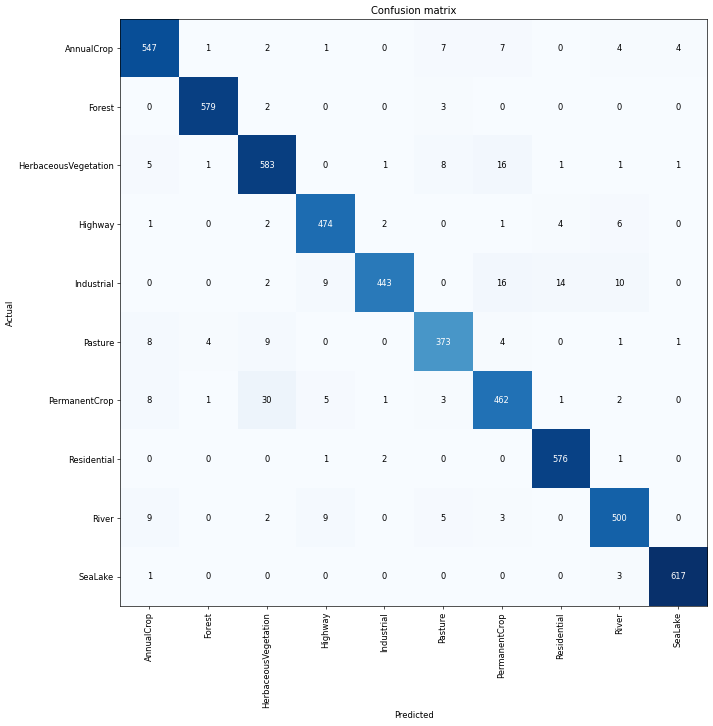

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [41]:
interp.most_confused(10)

[('PermanentCrop', 'HerbaceousVegetation', 30),
 ('HerbaceousVegetation', 'PermanentCrop', 16),
 ('Industrial', 'PermanentCrop', 16),
 ('Industrial', 'Residential', 14),
 ('Industrial', 'River', 10)]

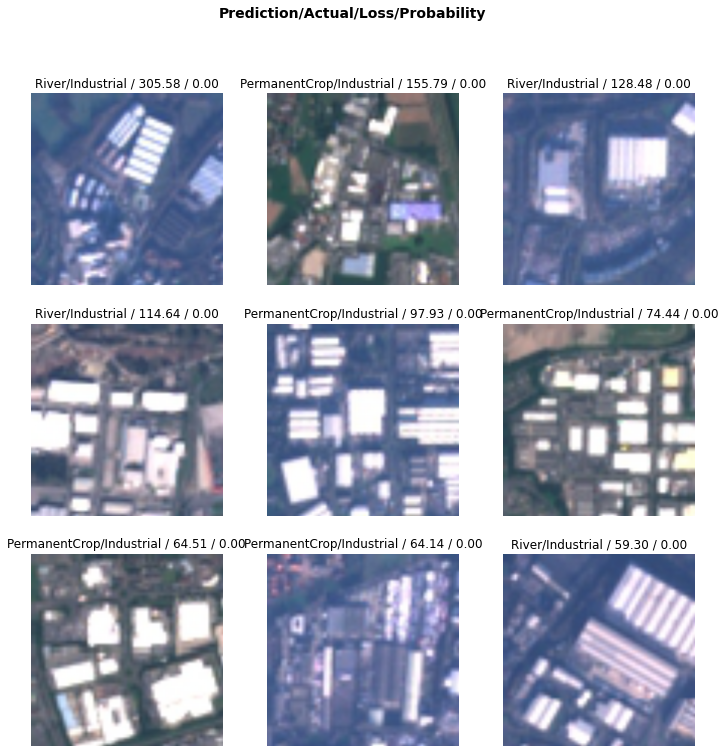

In [43]:
interp.plot_top_losses(9)

## 2.2. ResNet152

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 8.32E-03


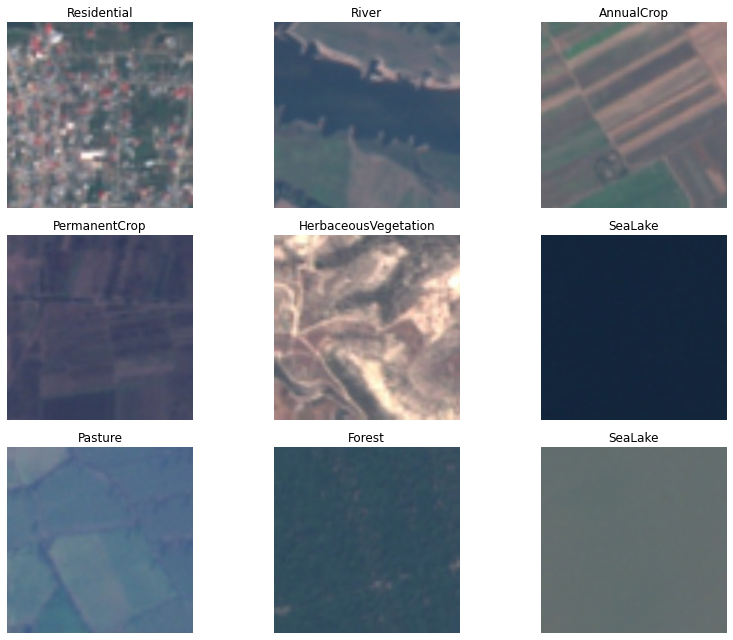

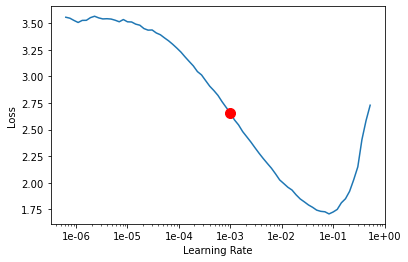

In [20]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet152, parameters, task="classification")
vis.find_alpha()


In [21]:
vis.learn.fit_one_cycle(15, 5e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.243739,0.152766,0.949444,02:49
1,0.191852,0.180938,0.942963,02:48
2,0.189292,0.181133,0.947222,02:49
3,0.195989,0.229904,0.929259,02:48
4,0.164202,0.139687,0.955926,02:48
5,0.117885,0.122988,0.960185,02:48
6,0.110638,0.096965,0.967407,02:51
7,0.098102,0.094620,0.973333,02:49
8,0.085800,0.081470,0.971482,02:48
9,0.060711,0.070339,0.978519,02:48


In [22]:
vis.learn.save(base_dir / "learn" / "euro-res152-1")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


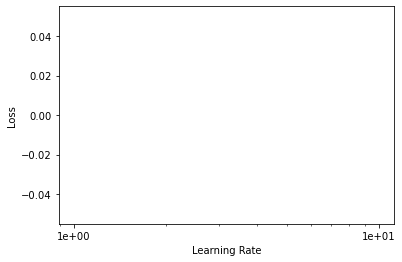

In [23]:
vis.learn.unfreeze()

vis.find_alpha()

In [24]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))
vis.learn.save(base_dir / "learn" / "euro-res152-2")

epoch,train_loss,valid_loss,accuracy,time
0,0.030220,0.033042,0.989815,03:44
1,0.029480,0.032324,0.989259,03:45
2,0.035853,0.035415,0.988333,03:44
3,0.034290,0.033197,0.989444,03:44
4,0.029395,0.037487,0.988333,03:44
5,0.028268,0.032614,0.988889,03:44
6,0.019711,0.033924,0.988333,04:00
7,0.019797,0.032522,0.988889,03:49
8,0.016933,0.031217,0.989259,03:51
9,0.018545,0.030747,0.989815,03:48


### Pretraining from Scratch

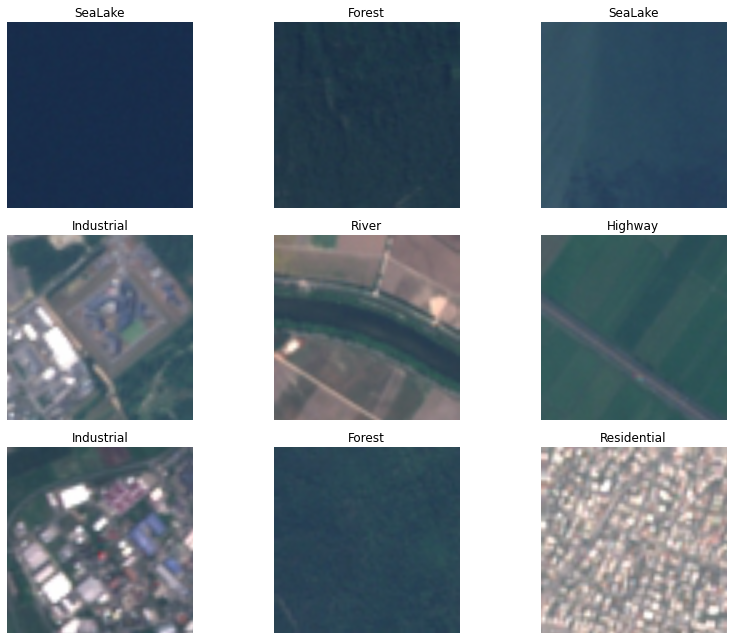

In [58]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet152, parameters, task="classification")

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 1.20E-02


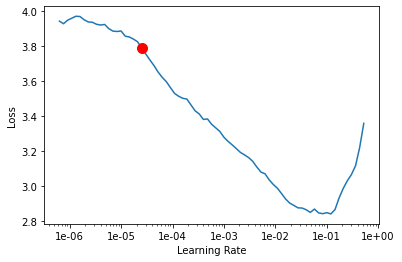

In [59]:
# import torch
# import torch.nn as nn


# vis.learn.model = torch.nn.DataParallel(vis.learn.model)
vis.find_alpha()

In [ ]:
vis.learn.fit_one_cycle(15, 5e-03)

epoch,train_loss,valid_loss,accuracy,f1_macro,f1_weighted,time
0,1.387892,0.944501,0.683704,0.644807,0.670752,02:39
1,1.171131,0.851568,0.697593,0.669984,0.696264,02:39
2,1.142934,1.398681,0.557037,0.502464,0.518267,02:39
3,0.988496,0.968989,0.668333,0.635688,0.668344,02:39
4,0.961558,29.378223,0.627037,0.568365,0.605662,02:39
5,0.761241,0.850183,0.714815,0.663313,0.690851,02:39
6,0.632926,73.511658,0.753333,0.721160,0.749616,02:39


In [ ]:
vis.learn.save(base_dir / "learn" / "euro-res152-r-1")